# Handwritten Digit Prediction using Linear Model
_Build a machine learning model to classify a handwritten digit using a linear model._

In [25]:
# Imports required packages

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

## Retrieving Data

The _MNIST_ is a database of handwritten digits with 784 features. The raw data available at http://yann.lecun.com/exdb/mnist/. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. The images were centered in a 28x28 image by computing the center of mass of the pixels, and translated the image so as to position this point at the center of the 28x28 field.

In [2]:
# Fetches the data set and caches it

# NOTE: This step may take several seconds to complete as it downloads 
# the data from web and then caches it locally

mnist = fetch_openml("mnist_784", as_frame=False)

In [3]:
# [OPTIONAL] Checks the available bunch objects
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


So, `mnist.data` and `mnist.target` will provide the data set and targets, respectively. Other properties might not be applicable as far as this experiment is concerned.

## Exploratory Data Analysis (EDA)

In [4]:
# Finds the shape of the data
print(mnist.data.shape)

(70000, 784)


In [5]:
# Similarly, finds the shape of the target
print(mnist.target.shape)

(70000,)


In [6]:
# Let's view target of first few observations
print(mnist.target[:20])

['5' '0' '4' '1' '9' '2' '1' '3' '1' '4' '3' '5' '3' '6' '1' '7' '2' '8'
 '6' '9']


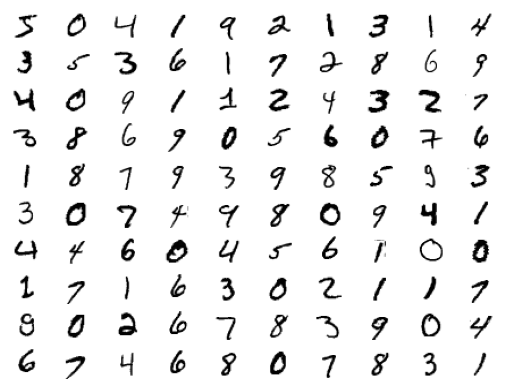

In [ ]:
# [OPTIONAL] Let's plot first 100 handwritten digits in a 10x10 subplots in a figure

for idx, image_data in enumerate(mnist.data[:100]):
    plt.subplot(10, 10, idx + 1)
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

plt.show()

## Modeling

In [12]:
# Converts target type from 'char' to 'integer'
mnist.target = mnist.target.astype(int)

In [13]:
# Split the data set into train and test data set.

# NOTE: Data set is already shuffled, and no further shuffling is being performed here.
# As recommended for this dataset, train and test set ratio maintained is 60000:10000.

X_train, X_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42, stratify=mnist.target)

In [45]:
# Checks values of the few of the labels
y_train

array([6, 9, 8, ..., 1, 8, 6])

In [15]:
# Instantiate scaler object to scale train set (with mean 0 and standard deviation 1)
std_scaler = StandardScaler()

# Scales the feature values
X_train_scaled = std_scaler.fit_transform(X_train)

In [17]:
# Transforms the test data using learned scaler
X_test_scaled = std_scaler.transform(X_test)

Models such as SGD classifier and random forest classifier have built-in feature to handle multiple classes. So, OvR or OvO strategy does not have to be specified for these models.

In [16]:
# Initialize the classifier
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

# Fits the model on train set
# NOTE: This step may take few minutes to complete
sgd_clf.fit(X_train_scaled, y_train)

SGDClassifier(n_jobs=-1, random_state=42)

In [23]:
# Performs predictions on the already scaled test set
predictions_test = sgd_clf.predict(X_test_scaled)

print(predictions_test)


[7 4 3 ... 6 9 3]


In [22]:
# Takes just one prediction and compares with the actual label
print("Prediction:", predictions_test[0])
print("Actual Label:", y_test[0])

Prediction: 7
Actual Label: 7


### Decision Function
_Alternate way of performing predictions other than calling `predict` method._

In [34]:
# Predict confidence score over decision function
decision_scores = sgd_clf.decision_function([X_test_scaled[0]])
print(decision_scores)

[[-1665.89532498  -597.98728775  -619.27388349  -436.01218819
   -718.01895306  -577.47512512 -1473.60295221   130.00328269
   -231.78643188   -42.18115073]]


In [35]:
# The class with the highest score gets predicted.

print("Prediction:", sgd_clf.classes_[decision_scores.argmax()])
print("Actual Label:", y_test[0])

Prediction: 7
Actual Label: 7


In [44]:
# Prints prediction performance of the model on test set
print("Prediction Performance (Accuracy) of SGD Classifier: {:.1f}%".format(accuracy_score(y_test, predictions_test) * 100))

Prediction Performance (Accuracy) of SGD Classifier: 90.2%


## Error Analysis
_Analyzing types of mistakes by looking into confusion matrix_

In [ ]:
# Performs cross-validation predictions
# NOTE: This step may take several minutes to complete

cv_predictions = cross_val_predict(
    sgd_clf, X_train_scaled, y_train, cv=5, n_jobs=-1, verbose=3, method="predict")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/pradip/anaconda3/envs/keras3/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min finished


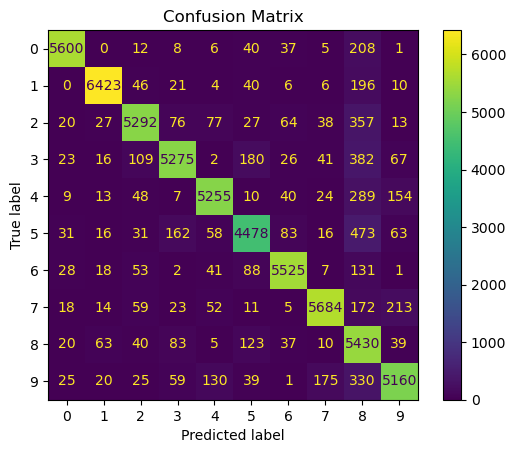

In [41]:
# Plots the confusion matrix

ConfusionMatrixDisplay.from_predictions(y_train, cv_predictions)

plt.title("Confusion Matrix")
plt.show()

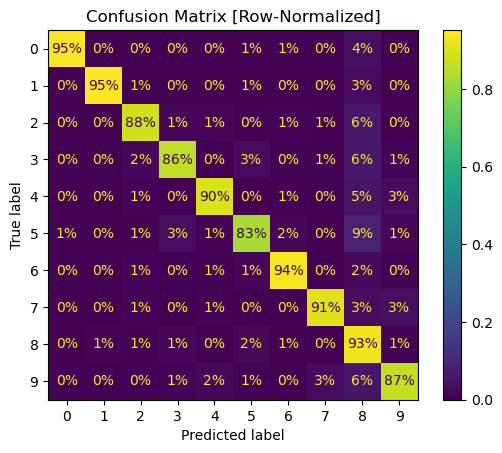

In [42]:
# Plots the normalized confusion matrix by dividing each value by the total number of images in the
# corresponding (true) class (i.e., divide by the row’s sum).
    
ConfusionMatrixDisplay.from_predictions(y_train, cv_predictions, normalize="true", values_format=".0%")

plt.title("Confusion Matrix [Row-Normalized]")
plt.show()

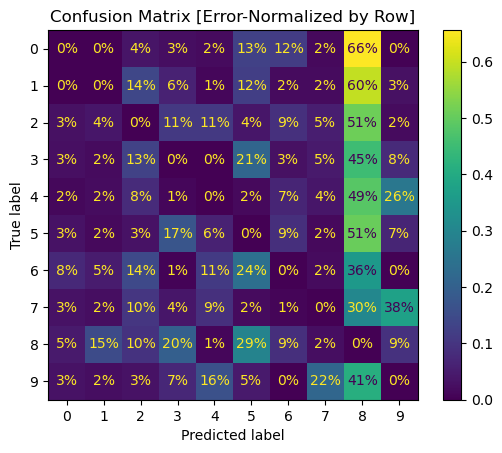

In [43]:
# Renders the confusion matrix to emphasis more on incorrect predictions than the correct predictions

sample_weight = (cv_predictions != y_train) 

ConfusionMatrixDisplay.from_predictions(
    y_train, cv_predictions, sample_weight=sample_weight, normalize="true", values_format=".0%")

plt.title("Confusion Matrix [Error-Normalized by Row]")
plt.show()


The column for class 8 is now really bright, which confirms that many images got misclassified as 8s. In fact this is the most common misclassification for  almost all classes.